In [ ]:
!pip install -q pylatexenc
!python -m pip install 'fsspec>=0.3.3'

In [ ]:
!pip install -q jsonlines natasha razdel langdetect

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import dask.bag as db
from pylatexenc.latex2text import LatexNodes2Text
import json
from razdel import tokenize
from nltk.corpus import stopwords
from string import punctuation
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger
from langdetect import detect
plt.style.use('seaborn')
tqdm.pandas()

In [ ]:
import jsonlines
cyberlink = []
for fl in [f'cyberleninka_{i}.jsonlines' for i in range(5)]:
    with jsonlines.open(fl, 'r') as jsonl_f:
        cyberlink += [obj for obj in jsonl_f]
len(cyberlink)

4072

In [ ]:
cyberlink[0]

{'abstract': 'Изложен метод проектирования устройств подачи нитки верхнего петлителя и определения рационального процесса ее потребления на основании использования диаграммы согласования функций подачи и потребления нитки верхнего петлителя при образовании трехниточного краеобметочного стежка 504 типа. Алгоритм, представленный для расчета диаграммы потребления нитки верхнего петлителя с учетом вероятных вариантов процесса взаимодействия рабочих органов, материала и нитки верхнего петлителя с ниткой нижнего петлителя, в совокупности с математическим аппаратом, используемый при этом, позволяет автоматизировать одну из особо сложных стадий в проектировании краеобметочной машины. Данный метод проектирования нитеподачи нитки верхнего петлителя будет полезен для разработчиков и эксплуатационников .The method of device design for thread feeding of the upper looper and for the consumption management uses the negotiation diagrams for the functions of thread feeding and consumption of the head l

In [ ]:
def split_lang(txt):
    rus = ''
    eng = ''
    for sent in txt.split('.'):
        try:
            if detect(sent) == 'ru':
                rus += sent + '.'
            else:
                eng += sent + '.'
        except:
            continue
    return rus, eng

abstract_rus_link = []
abstract_eng_link = []

for sup in tqdm(cyberlink, desc='extracting abstracts'):
    abstr = sup['abstract']
    r, e = split_lang(abstr)
    abstract_rus_link.append(r)
    abstract_eng_link.append(e)

extracting abstracts:   0%|          | 0/4072 [00:00<?, ?it/s]

In [ ]:
import jsonlines
habr = []
for fl in [f'habrahabr_{i}.jsonlines' for i in range(4)]:
    with jsonlines.open(fl, 'r') as jsonl_f:
        habr += [obj for obj in jsonl_f]
len(habr)

3990

In [ ]:
habr[0]

{'content': ' MassTransit это open source библиотека, разработанная на языке C# для .NET платформы, упрощающая работу с шиной данных, которая используется при построении распределенных приложений и реализации SOA (service oriented architecture). \r\nВ качестве message broker могут выступать RabbitMq, Azure Service Bus или In-Memory менеджер (в случае с In-Memory область видимости ограничивается процессом, в котором проинициализирован экземпляр). Содержание: Команды и события Команды \r\n События \r\n \r\n Контракты сообщений \r\n Роутинг Exchange \r\n Формат сообщения \r\n \r\n Консьюмеры (Consumer) \r\n Конфигурация контейнера DI \r\n Наблюдатели (Observer) \r\n Новое в MassTransit 3.0 \r\n Заключение \r\n Опрос: А какую .NET библиотеку используете вы? \r\n Команды и события \r\nВ библиотеке заложено 2 основных типа сообщений: команды и события. Команды \r\nСигнализируют о необходимости выполнить некое действие. Для наиболее содержательного наименования команды желательно использовать

In [ ]:
summaries_habr = [x['summary'] for x in habr]

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def clean_abstract(txt, stp_wrds):
    txt = txt.lower()
    try:
        txt = LatexNodes2Text().latex_to_text(txt)
    except:
        txt = txt.lower()

    doc = Doc(txt)
    sup = word_tokenize(txt, language="english")
    lemmatizer = WordNetLemmatizer()
    sup = [lemmatizer.lemmatize(word) for word in sup]
    ret = []
    for el in sup:
        el.replace('\\', '')
        if el not in stp_wrds and el not in string.punctuation:
            ret.append(el)
    
    return ' '.join(ret)


stop_words = nltk.corpus.stopwords.words("english")
stop_words += ['we', 'paper', 'new', 'article', "''", "``", "”", 'et', 'al', 'study', 'state', 'of', 'the', 'art']
cleaned_abstract_e_link = [clean_abstract(x, stop_words) for x in tqdm(abstract_eng_link, desc='cleaning')]

cleaning:   0%|          | 0/4072 [00:00<?, ?it/s]

In [ ]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
    text = text.lower()
    try:
        text = LatexNodes2Text().latex_to_text(text)
    except:
        text = text.lower()
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    return [_.lemma for _ in doc.tokens]

def cleaner(txt, noise):
    res = []
    for word in txt:
        if word not in noise:
            res.append(word)
    return ' '.join(res)

def prep(txt_list):
    noise = stopwords.words('russian') + list(punctuation) + ['что', 'то', 'кто', 'привет', 'весь', 'всем', 'какой', 'ваш', 'внимание', 'добрый', 'время', 'сатья', 'данный', 'хотеть', 'рассказать', 'посвятить', 'результат', 'результаты', 'представить', 'привести']
    for i in tqdm(range(len(txt_list))):
        txt_list[i] = cleaner(natasha_lemmatize(txt_list[i]), noise)
cleaned_abstract_r_link = abstract_rus_link.copy()
prep(cleaned_abstract_r_link)
abstract_rus_link[0], cleaned_abstract_r_link[0]

  0%|          | 0/4072 [00:00<?, ?it/s]

('Изложен метод проектирования устройств подачи нитки верхнего петлителя и определения рационального процесса ее потребления на основании использования диаграммы согласования функций подачи и потребления нитки верхнего петлителя при образовании трехниточного краеобметочного стежка 504 типа. Алгоритм, представленный для расчета диаграммы потребления нитки верхнего петлителя с учетом вероятных вариантов процесса взаимодействия рабочих органов, материала и нитки верхнего петлителя с ниткой нижнего петлителя, в совокупности с математическим аппаратом, используемый при этом, позволяет автоматизировать одну из особо сложных стадий в проектировании краеобметочной машины. Данный метод проектирования нитеподачи нитки верхнего петлителя будет полезен для разработчиков и эксплуатационников .',
 'изложить метод проектирование устройство подача нитка верхний петлитель определение рациональный процесс потребление основание использование диаграмма согласование функция подача потребление нитка верхний

In [ ]:
natasha_lemmatize('Я иду домой')

['я', 'идти', 'домой']

In [ ]:
cleaned_summaries_habr = summaries_habr.copy()
prep(cleaned_summaries_habr)
summaries_habr[0], cleaned_summaries_habr[0]

  0%|          | 0/3990 [00:00<?, ?it/s]

('MassTransit это open source библиотека, разработанная на языке C# для .NET платформы, упрощающая работу с шиной данных, которая используется при построении распределенных приложений и реализации...',
 'masstransit это open source библиотека разработать язык c net платформа упрощать работа шина данные который использоваться построение распределить приложение реализация ...')

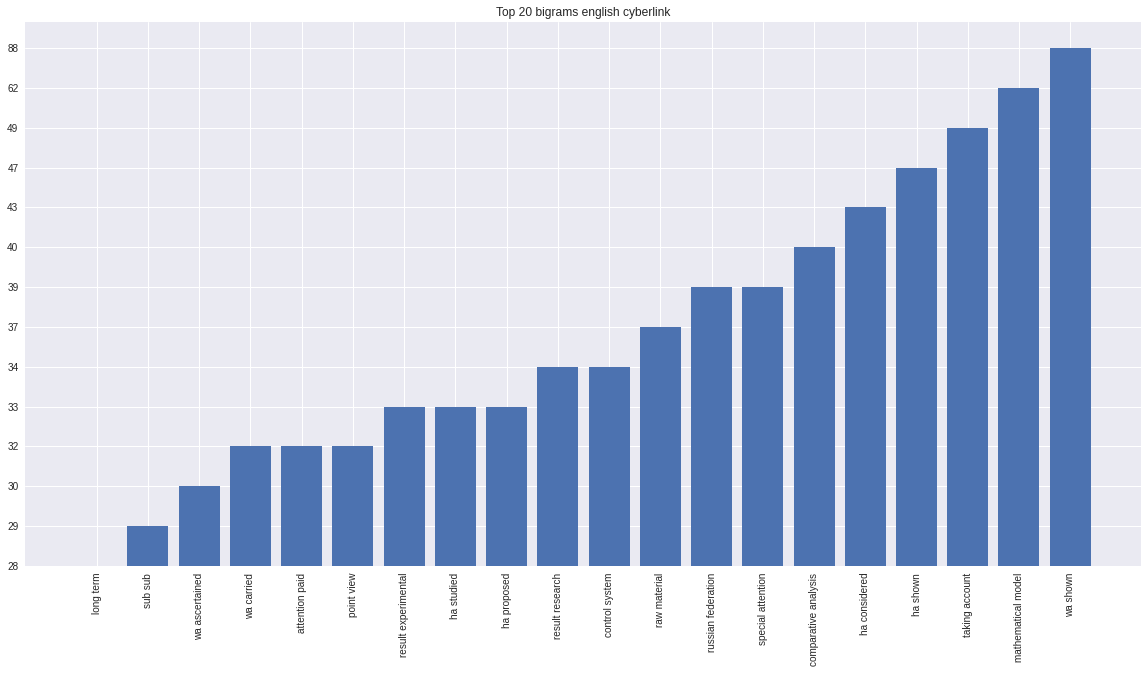

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [[word, sum_words[0, idx]] for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return np.array(words_freq[:n])

common_words = get_top_n_bigram(cleaned_abstract_e_link, 20)
common_words.sort()
common_words = np.flip(common_words)
x = common_words[:, 0]
y = common_words[:, 1]
_, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Top 20 bigrams english cyberlink')
_ = ax.bar(x, y, align='center', bottom=0)
_= plt.xticks(rotation=90)

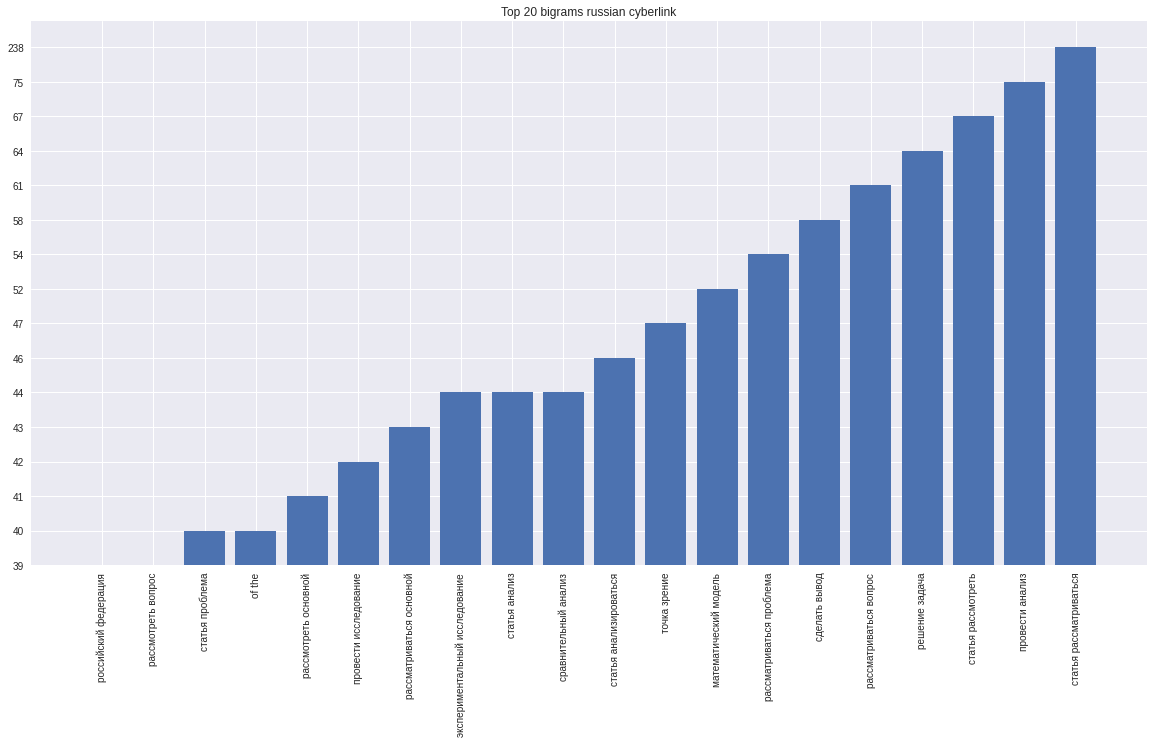

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [[word, sum_words[0, idx]] for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return np.array(words_freq[:n])

common_words = get_top_n_bigram(cleaned_abstract_r_link, 20)
common_words.sort()
common_words = np.flip(common_words)
x = common_words[:, 0]
y = common_words[:, 1]
_, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Top 20 bigrams russian cyberlink')
_ = ax.bar(x, y, align='center', bottom=0)
_= plt.xticks(rotation=90)

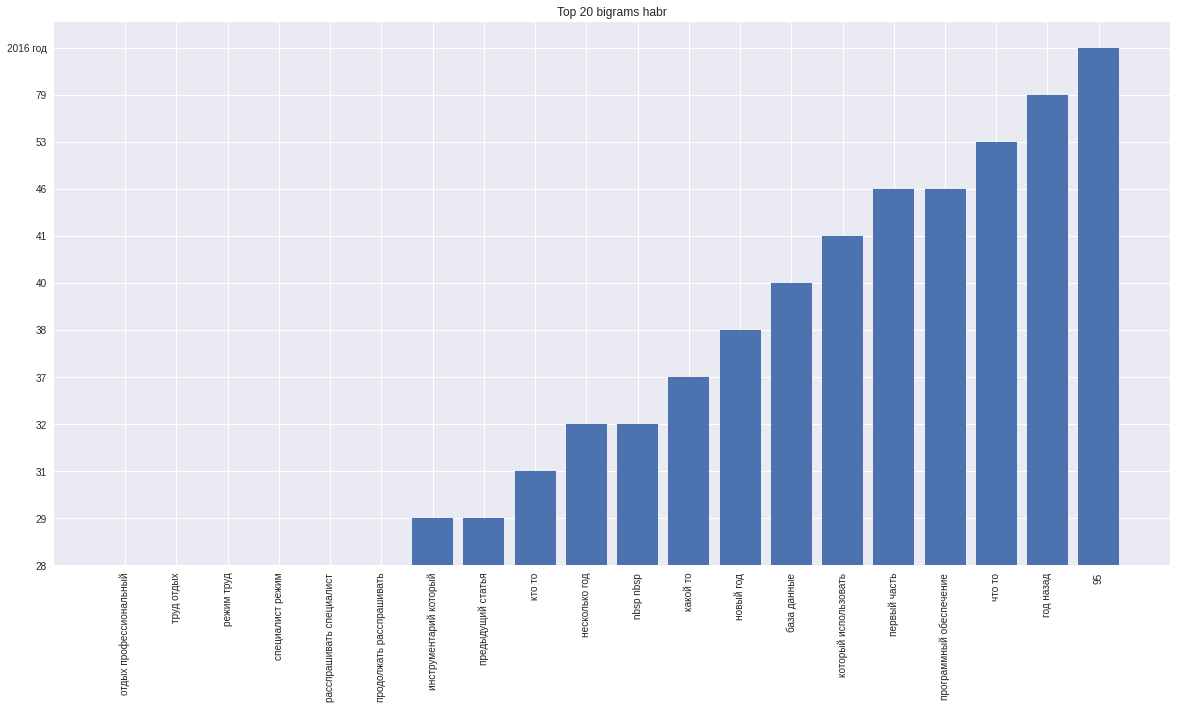

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [[word, sum_words[0, idx]] for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return np.array(words_freq[:n])

common_words = get_top_n_bigram(cleaned_summaries_habr, 20)
common_words.sort()
common_words = np.flip(common_words)
x = common_words[:, 0]
y = common_words[:, 1]
_, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Top 20 bigrams habr')
_ = ax.bar(x, y, align='center', bottom=0)
_= plt.xticks(rotation=90)

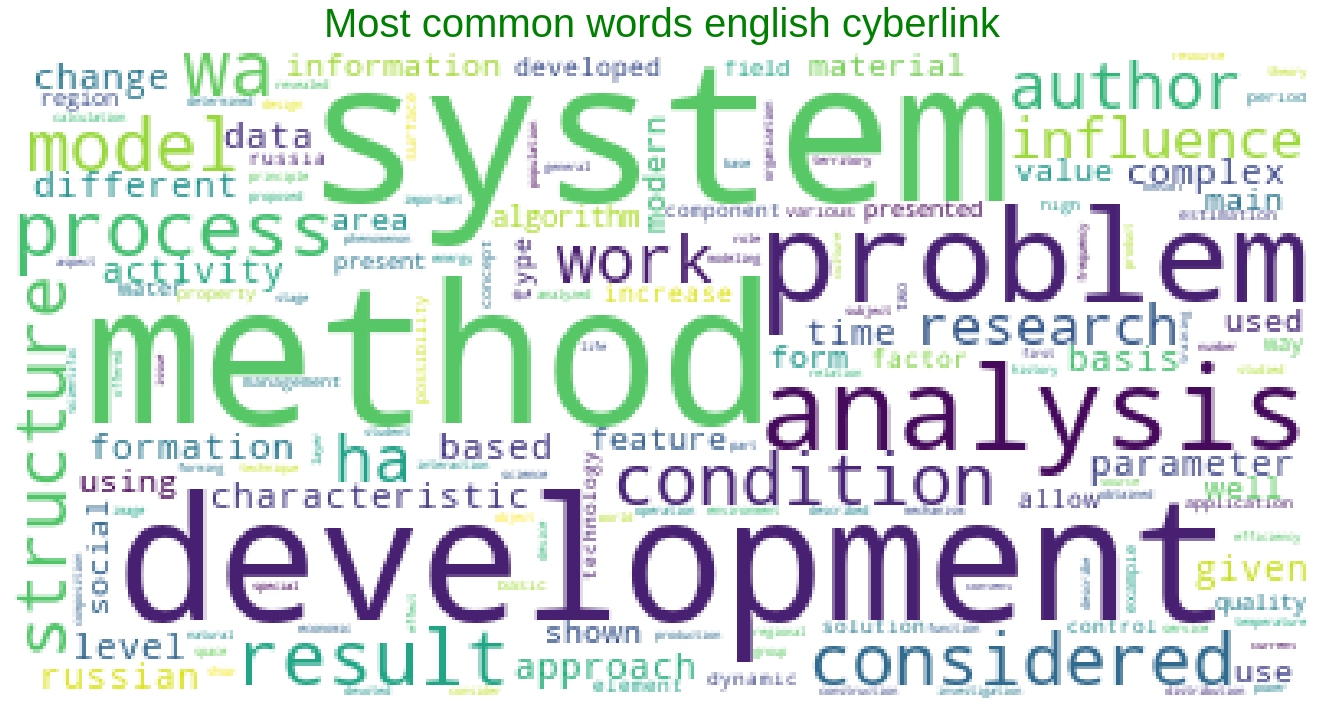

In [ ]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                          stopwords = stopwords,
                          max_words = max_words,
                          max_font_size = max_font_size,
                          random_state = 42,
                          mask = mask)
    wordcloud.generate(text)

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                   'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green',
                                   'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

plot_wordcloud(str(cleaned_abstract_e_link), max_words=800, max_font_size=60, figure_size=(20, 10),
               title = 'Most common words english cyberlink')

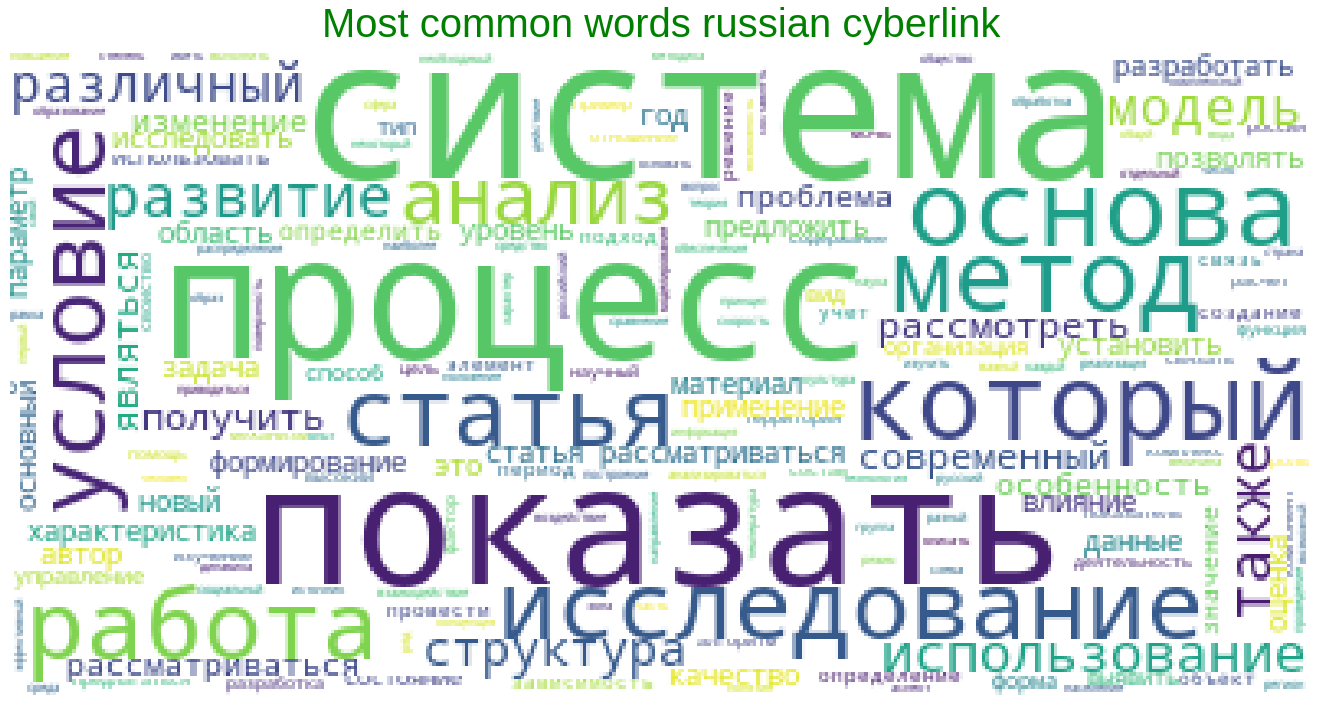

In [ ]:
plot_wordcloud(str(cleaned_abstract_r_link), max_words=800, max_font_size=60, figure_size=(20, 10),
               title = 'Most common words russian cyberlink')

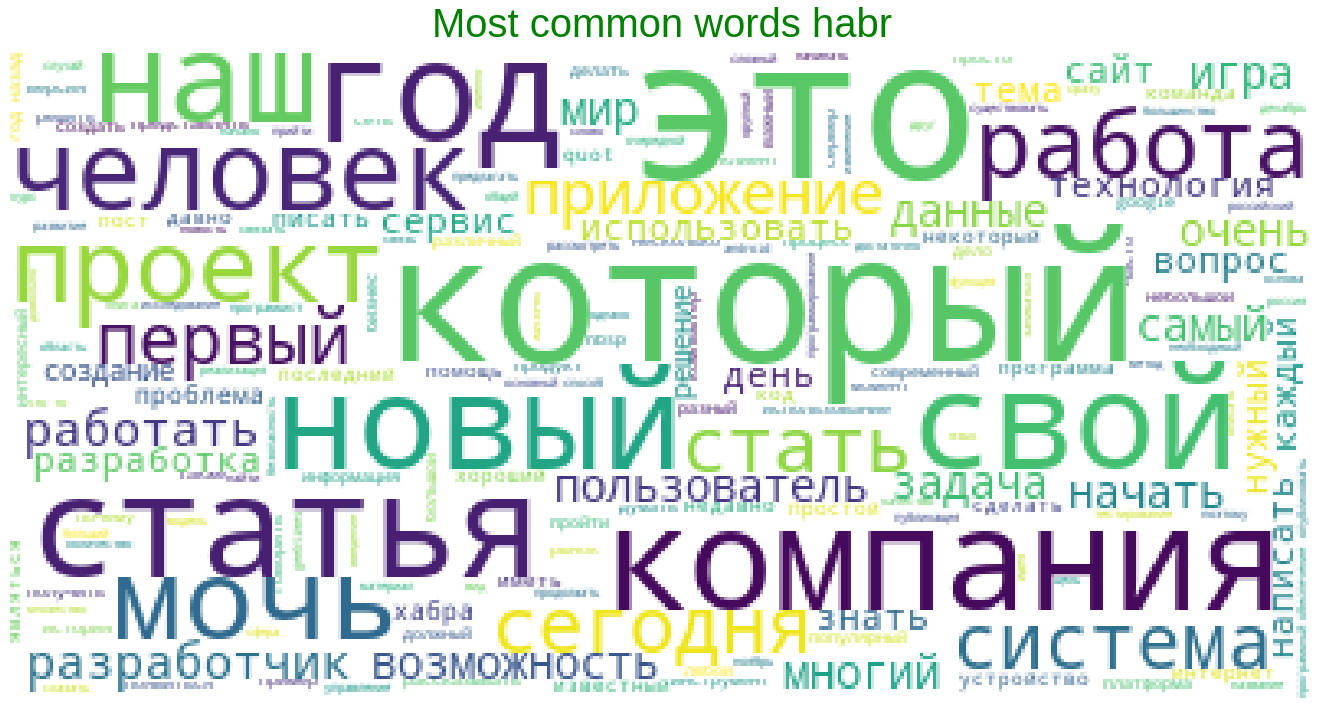

In [ ]:
plot_wordcloud(str(cleaned_summaries_habr), max_words=800, max_font_size=60, figure_size=(20, 10),
               title = 'Most common words habr')